In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.formula.api as smf

from sklearn.pipeline import Pipeline
from sklearn import ensemble, neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from scipy import stats
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest, f_classif

import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams.update({'font.size': 25})
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Background 

This is a synthetic financial dataset created for fraud detection generated by Paysim. PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

Fraud in this context is defined as fraudulent mobile money transactions where an agent attempts to gain access to a customer's account and empty the funds by transferring to another account and cashing out of the system.

This synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle. The link can be found here: https://www.kaggle.com/ntnu-testimon/paysim1

# Project Goal

Given the dataset presented, I create models that can accurately detect fraud. The goal is to see which model will have the strongest performance. Strongest in this case will be defined by model computation time and model accuracy.

## Attribute Information:

This is a sample of 1 row with headers explanation:

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [2]:
paysim_data = pd.read_csv('paysim.csv')

#  Exploratory Data Analysis

In [3]:
paysim_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
# Check how many rows and columns there are.
paysim_data.shape

(6362620, 11)

In [5]:
paysim_data.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

- Most things are numbers which will make the data easier to use later. 
- Type will be easy to change into a numerical type, but nameOrig and nameDest might be neglected due to there being too many unique ids.


In [6]:
# Lets check to see if there are any null values.
paysim_data.isnull().values.any()

False

In [7]:
# Look at the summary of the data. 
paysim_data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


There don't seem to be any outliers juding from the max, standard deviations, and means except for amount. However, amount having outliers shouldn't be too much of a problem for what I'm trying to do. 

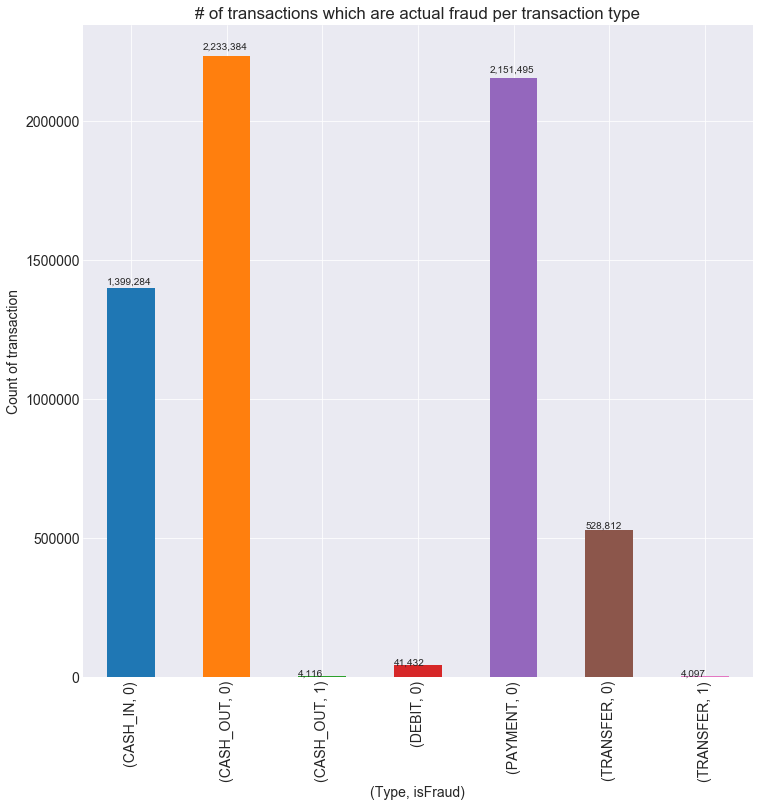

In [39]:
ax = paysim_data.groupby(['type', 'isFraud']).size().plot(kind='bar')
ax.set_title("# of transactions which are actual fraud per transaction type")
ax.set_xlabel("(Type, isFraud)")
ax.set_ylabel("Count of transaction")
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams.update({'font.size': 10})
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01));

From the bar graph we can see that the only time there is fraud is when there is a cash out or transfer occurrence. Another thing to notice is that cash out and transfer both have a similar amount of fraudulent transactions.  

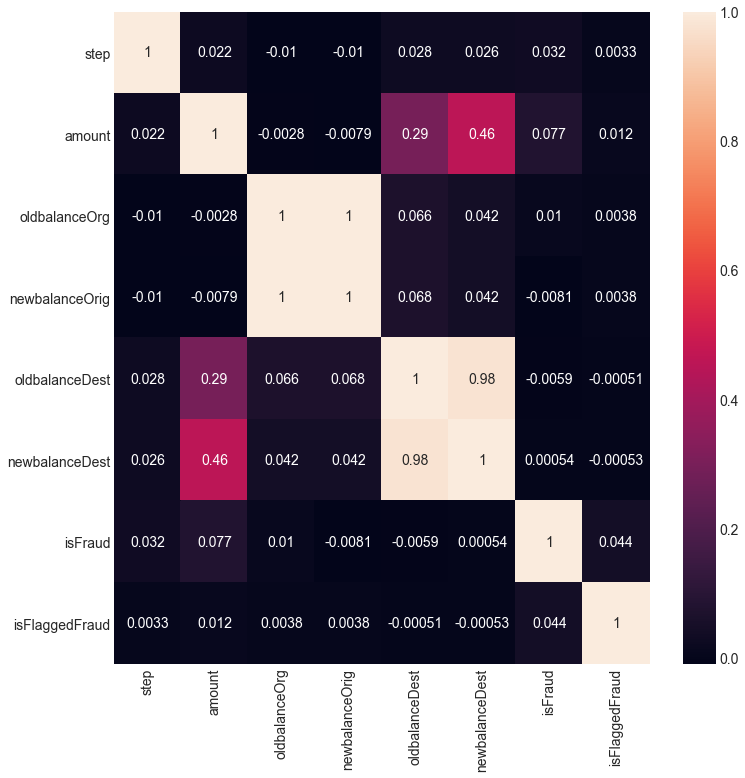

In [38]:
# Create a heatmap to see if there is any multicollinearity.
fraud = paysim_data.groupby('isFraud')
plt.rcParams['figure.figsize'] = (12.0, 12.0)
plt.rcParams.update({'font.size': 14})
sns.heatmap(paysim_data.corr(), annot=True);

We can see that the data doesn't really suffer from any extreme positive or negative multicollinearity besides the old and new balance orig/destination but we will work with that later.

# Data Modification

In [3]:
# Show what unique variables there are for type. 
list(paysim_data['type'].unique())

['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN']

In [4]:
# Convert type into a continuous variable.
type_dummies = pd.get_dummies(paysim_data['type'])

# concatenate the dummies with the original dataset.
paysim_data = pd.concat([paysim_data, type_dummies], axis=1)

In [5]:
# Create a droplist for data that I cannot use for my models.
droplist = ['nameOrig', 'nameDest', 'type']

# Create a new data subset
new_paysim = paysim_data.drop(droplist, 1)

In [14]:
# One last check to see that everything is ready to go.
new_paysim.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,0,1,0


In [6]:
# Check if we have an even distribution of fraud
new_paysim['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

- .129% of the data is actually fradulent. 

- Since this dataset has imbalanced data between fraud and non fraud, I will downsample the data so that there will be an even distribution. I'm choosing to downsample because there is a lot of data if I were to upsample.

In [7]:
from sklearn.utils import resample
# Lets resample to 100,000 since the dataset is so big.
# So less nonfraudulent samples.
paysim_majority = new_paysim[new_paysim.isFraud==0]
paysim_minority = new_paysim[new_paysim.isFraud==1]

# Downsample majority class
paysim_majority_downsampled = resample(paysim_majority, 
                                 replace=True,     # sample with replacement
                                 n_samples=100000)  

# Upsample minority class
paysim_minority_upsampled = resample(paysim_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=100000)  
 
# Combine downsampled majority class with minority class
paysim_resampled = pd.concat([paysim_majority_downsampled, paysim_minority_upsampled])
 
# Display new class counts
paysim_resampled.isFraud.value_counts()

1    100000
0    100000
Name: isFraud, dtype: int64

In [8]:
# Time to create a training and test set
# Set up variables
X = paysim_resampled.drop('isFraud', 1)
y = paysim_resampled.isFraud
# Create training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Now the modeling begins.

# Model 1: Naive Bayes

In [30]:
# Our data continuous, so we're importing the Gaussian classifier.
from sklearn.naive_bayes import GaussianNB

# Instantiate our model and store it in a new variable.
gnb = GaussianNB()

# Fit our model to the data.
gnb.fit(X_train, y_train)

# Classify, storing the result in a new variable.
y_pred_train = gnb.predict(X_test)

# Display our results.
print(str(100*gnb.fit(X_train, y_train).score(X_test, y_test)) + '%')

69.79833333333333%


In [21]:
# Cross Validate the model.
cross_val_score(gnb, X_train, y_train, cv=10)

array([0.69980716, 0.68602243, 0.69528571, 0.70007143, 0.702     ,
       0.694     , 0.69221429, 0.693     , 0.70383599, 0.70719337])

In [31]:
# Create a confusion matrix.
confusion_matrix(y_test, y_pred_train)

array([[29229,   813],
       [17308, 12650]])

In [23]:
# Create a classification report.
print(classification_report(y_test, y_pred_train))

             precision    recall  f1-score   support

          0       0.63      0.97      0.76     30042
          1       0.94      0.42      0.58     29958

avg / total       0.78      0.70      0.67     60000



In [126]:
from sklearn.metrics import auc, precision_recall_curve

# Check the area under the precision recall curve. 
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_train)

auc(precision, recall)

0.3258683824798824

# Analysis

I chose to use the Gaussian Naive Bayes because GNB allowed for continuous variables, while Bernoulli required features that were binary and the Multinomial NB wasn't as suitable since those features are supposed to be more a count than a continuous variable type. The accuracy of this model was only 75% or so which is reasonable in my opinion due to the fact that 'isFlaggedFraud' is a binary classifier which probably inhibited the predictive ability of GaussianNB. The main culprit in this model's accuracy is the type II error where it's failing to recognize fraud, giving a false negative.


The computational run time of this model was pretty quick since I didn't have any in depth feature selection for this model. Although it was quick, it wasn't as accurate.


# Model 2: KNN

In [36]:
from sklearn.preprocessing import StandardScaler

# Instantiate StandardScaler
ss = StandardScaler()

# Set up the variables.
# Set up variables
X = paysim_resampled.drop('isFraud', 1)
y = paysim_resampled['isFraud'].values.reshape(-1, 1)

# Standarize the data first 
ss.fit(X,y)

# Now that the data is ready
transform_x = ss.transform(X, y)

In [37]:
# Create training and testing set for knn
knn_Xtrain, knn_Xtest, knn_ytrain, knn_ytest = train_test_split(transform_x, y, test_size=0.3)

In [44]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the model and SelectKBest features
knn = KNeighborsClassifier()

# Let all of the features be an option
kbest = SelectKBest(f_classif)

# Instantiate pipeline
knn_pipeline = Pipeline([('kbest', kbest), ('knn', KNeighborsClassifier())])

knn_params = {'kbest__k': [1,2,3,4,5,6,7,8,9,10,11,12],
                                     'knn__n_neighbors':[2,4,5,7,9,10,20,40,50,75]}

# Set up parameters
knn_grid = GridSearchCV(knn_pipeline, knn_params, cv=5, verbose=1, n_jobs=-1)

# Fit the grid and obtain results
knn_grid.fit(knn_Xtrain, knn_ytrain)

# Return best parameters and best score
print('Best parameters:')
print(knn_grid.best_params_)
print('Best Score:')
print(knn_grid.best_score_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 45.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 70.9min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 124.2min finished


Best parameters:
{'kbest__k': 8, 'knn__n_neighbors': 2}
Best Score:
0.9937428571428571


In [49]:
# Set up the best parameters
best_param = {'kbest__k': [8],'knn__n_neighbors': [2]}

# Set up a new grid
best_knn_grid = GridSearchCV(knn_pipeline, best_param, cv=5, verbose=1, n_jobs=-1)

# Lets cross validate.
cross_val_score(best_knn_grid, knn_Xtrain, knn_ytrain, cv=5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.2s remaining:   21.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   44.6s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   15.3s remaining:   23.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   15.4s remaining:   23.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.5s remaining:   20.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished


array([0.9936788 , 0.99321429, 0.99421429, 0.99421429, 0.99339262])

In [50]:
# Fit our model to the data.
best_knn_grid.fit(knn_Xtrain, knn_ytrain)

# Classify, storing the result in a new variable.
knn_pred = best_knn_grid.predict(knn_Xtest)

# Create a confusion matrix.
confusion_matrix(knn_ytest, knn_pred)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   25.9s remaining:   38.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.3s finished


array([[29540,   311],
       [    0, 30149]])

In [51]:
# Create a classification report.
print(classification_report(knn_ytest, knn_pred))

             precision    recall  f1-score   support

          0       1.00      0.99      0.99     29851
          1       0.99      1.00      0.99     30149

avg / total       0.99      0.99      0.99     60000



In [98]:
# Check the area under the precision recall curve. 
precision, recall, thresholds = precision_recall_curve(knn_ytest, knn_pred)

auc(precision, recall)

0.005105055810899539

# Analysis

The KNN model was accurate due to the fact that I had first normalized the features in this model so that it could correctly calculate the euclidean distance. This means that the nearest neighbors were mostly correctly classified. However, due to the 99% accuracy of the model, I believe that my model has been overfitted with data given the fact that there were 200,000 rows of data that was plugged in. 

Although I used SelectKBest to help me filter out the important features for this model, the fact that it only needed two neighbors to classify if something was fraud or not is concerning. Even after using a confusion matrix and the classification report to look at the model's ability to recognize false positives/negatives, the results still felt suspicious. Using the AUC (area under the curve), I saw that this model was only able to explain about 5% of the precision (tp/(tp +fp)) and recall (tp/(tp + fn)) generated by this model.

Although this model is quite fast this model's accuracy is actually quite low due to the fact that it had been fed too much data. 

# Model 3: Decision Tree

In [58]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the model
dtc = DecisionTreeClassifier()

# Instantiate pipeline
dtc_pipeline = Pipeline([('kbest', kbest), ('dtc', DecisionTreeClassifier())])

dtc_params = {'kbest__k': [1,2,3,4,5,6,7,8,9,10,11,12],
                        'dtc__max_depth':[2,4,6,8]}

# Set up parameters
dtc_grid = GridSearchCV(dtc_pipeline, dtc_params, cv=5, verbose=1, n_jobs=-1)

# Fit the grid and obtain results
dtc_grid.fit(X_train, y_train)

# Return best parameters and best score
print('Best parameters:')
print(dtc_grid.best_params_)
print('Best Score:')
print(dtc_grid.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   15.1s finished


Best parameters:
{'dtc__max_depth': 8, 'kbest__k': 10}
Best Score:
0.9876


In [60]:
# Set up the best parameters
best_param = {'kbest__k': [10],'dtc__max_depth': [8]}

# Set up a new grid
best_dtc_grid = GridSearchCV(dtc_pipeline, best_param, cv=5, verbose=1, n_jobs=-1)

# Cross Validate the decision tree model. 
cross_val_score(best_dtc_grid, X_train, y_train, cv=5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


array([0.9860005 , 0.98867898, 0.98814286, 0.98742812, 0.9876067 ])

In [66]:
# Fit our model to the data.
best_dtc_grid.fit(X_train, y_train)

# Classify, storing the result in a new variable.
dtc_pred = best_dtc_grid.predict(X_test)

# Create a confusion matrix.
confusion_matrix(y_test, dtc_pred)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


array([[29399,   643],
       [   80, 29878]])

In [67]:
# Create a classification report.
print(classification_report(y_test, dtc_pred))

             precision    recall  f1-score   support

          0       1.00      0.98      0.99     30042
          1       0.98      1.00      0.99     29958

avg / total       0.99      0.99      0.99     60000



In [110]:
# Check the area under the precision recall curve. 
precision, recall, thresholds = precision_recall_curve(y_test, dtc_pred)

auc(precision, recall)

0.4894977331758449

# Analysis

The accuracy of the decision tree was extremely high. This model was able to obtain such a high accuracy by using the maximum amount of depth to explain the variance (lower the entropy) of the dataset to the minimum allowing the decision tree to become a strong classifier. Although this model is still a bit overfitted since the AUC score was only 48%. 

The decision tree is a relatively strong performer in this dataset since it was quick and it's had the highest level of accuracy so far. 

# Model 4: Random Forest Classifier

In [63]:
# Prepare to use the random forest 
rfc = ensemble.RandomForestClassifier()


# Instantiate pipeline
rfc_pipeline = Pipeline([('kbest', kbest), ('rfc', ensemble.RandomForestClassifier())])

# Create rfc parameters for GS-CV
param_grid = {'kbest__k': [1,2,3,4,5,6,7,8,9,10,11,12],
              'rfc__n_estimators': [10, 25, 50, 75, 100, 200, 500, 1000],
             'rfc__max_depth': [2, 4, 6]}

# Set up GS-CV
rfc_grid = GridSearchCV(rfc_pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)

rfc_grid.fit(X_train, y_train)

# Show the best parameter and best score for unfiltered
print('Best Parameter for data:', rfc_grid.best_params_)
print('\nBest Score for data:', rfc_grid.best_score_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 52.8min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 66.3min finished


Best Parameter for data: {'kbest__k': 9, 'rfc__max_depth': 6, 'rfc__n_estimators': 75}

Best Score for data: 0.9746357142857143


In [65]:
# Set up the best parameters
best_param = {'kbest__k': [9],'rfc__max_depth': [6], 'rfc__n_estimators':[75]}

# Set up a new grid
best_rfc_grid = GridSearchCV(rfc_pipeline, best_param, cv=5, verbose=1, n_jobs=-1)

# Cross Validate the random forest model.  
cross_val_score(best_rfc_grid, X_train, y_train, cv=5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.9s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.3s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.5s remaining:    9.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.7s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.0s remaining:   10.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished


array([0.97289383, 0.97260812, 0.96935714, 0.97478481, 0.97221329])

In [68]:
# Fit our model to the data.
best_rfc_grid.fit(X_train, y_train)

# Classify, storing the result in a new variable.
rfc_pred = best_rfc_grid.predict(X_test)

# Create a confusion matrix.
confusion_matrix(y_test, rfc_pred)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.2s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.5s finished


array([[29113,   929],
       [  349, 29609]])

In [69]:
# Create a classification report.
print(classification_report(y_test, rfc_pred))

             precision    recall  f1-score   support

          0       0.99      0.97      0.98     30042
          1       0.97      0.99      0.98     29958

avg / total       0.98      0.98      0.98     60000



In [111]:
# Check the area under the precision recall curve. 
precision, recall, thresholds = precision_recall_curve(y_test, rfc_pred)

auc(precision, recall)

0.4825729545782853

# Analysis

This is an ensemble method which means that this model is a conglomeration of weak learners, or in this case, 75 trees. It's no surprise that this model did well due to the fact that given a deeper death, and more runs, this allows the model to know more about the dataset. However, the 99% accuracy score indicates to me that the model is falling for the noise in the dataset. After checking the AUC, I can see that this random forest still only performs about as well as the decision tree.

In terms of accuracy, this has been the strongest performer so far, but it fails in computational time since it took me around 2.5 hours for this model to finish running.

# Model 5: Logistic Regression

In [71]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

# Use GS-CV to see which alpha level is best.

# Instantiate pipeline
lr_pipeline = Pipeline([('kbest', kbest), ('lr', LogisticRegression(penalty='l2'))])

# Create rfc parameters for GS-CV
param_grid = {'kbest__k': [1,2,3,4,5,6,7,8,9,10,11,12],
              'lr__C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,10000,100000,100000000]}


# Set up GS-CV
lr_grid = GridSearchCV(lr_pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)

#Fit the logistic regression 
lr_grid.fit(X_train, y_train)

#return best parameters and best score
print('Best parameters:')
print(lr_grid.best_params_)
print('Best Score:')
print(lr_grid.best_score_)

Fitting 5 folds for each of 132 candidates, totalling 660 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 660 out of 660 | elapsed:  1.3min finished


Best parameters:
{'kbest__k': 8, 'lr__C': 1e-05}
Best Score:
0.9073357142857142


In [80]:
# Implement parameter 
lr = LogisticRegression(C=1e-05, penalty='l2')

# Cross Validate the lr model. 
cross_val_score(lr, X_train, y_train, cv=5)

array([0.90325346, 0.90850327, 0.90867857, 0.90788957, 0.90531805])

In [77]:
# Fit our model to the data.
best_lr.fit(X_train, y_train)

# Classify, storing the result in a new variable.
lr_pred = best_lr.predict(X_test)

# Create a confusion matrix.
confusion_matrix(y_test, lr_pred)

array([[27435,  2607],
       [ 2930, 27028]])

In [79]:
# Create a classification report.
print(classification_report(y_test, lr_pred))

             precision    recall  f1-score   support

          0       0.90      0.91      0.91     30042
          1       0.91      0.90      0.91     29958

avg / total       0.91      0.91      0.91     60000



In [127]:
# Check the area under the precision recall curve. 
precision, recall, thresholds = precision_recall_curve(y_test, lr_pred)

auc(precision, recall)

0.43222971812807204

# Analysis

For the logistic regression model, I had chose to use the ridge regularization to penalize this model due to the amount of rows I had in this dataset. Using the ridge regularization allowed me to avoid the overfitting of the coefficients and I want to avoid increasing the size of the coefficient because it means that the feature related to that coefficient will have more weight on the model itself. In order to avoid overweighting the importance of the features, I had to use the ridge regularization. 

Looking at the best penalty parameter, I can see that there was a stronger regularization since it was 1e-05. This model did slightly worse in terms of accuracy compared to the decision tree and random forest, but its computation time was pretty fast which is noteworthy.

# Model 6: Gradient Boosting Model

In [101]:
# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier()

# Instantiate pipeline
clf_pipeline = Pipeline([('kbest', kbest), ('clf', ensemble.GradientBoostingClassifier())])

# Create rfc parameters for GS-CV
param_grid = {'kbest__k': [1,2,3,4,5,6,7,8,9,10,11,12],
              'clf__n_estimators': [100,200,500,800,1000],
             'clf__max_depth': [2,4,6]}


# Set up GS-CV
clf_grid = GridSearchCV(clf_pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)

#Fit the logistic regression 
clf_grid.fit(X_train, y_train)


# Return best parameters and best score
print('Best parameters:')
print(clf_grid.best_params_)
print('Best Score:')
print(clf_grid.best_score_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 54.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 178.0min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 279.7min finished


Best parameters:
{'clf__max_depth': 6, 'clf__n_estimators': 1000, 'kbest__k': 12}
Best Score:
0.9985357142857143


In [102]:
# Set up the best parameters
best_clf_param = {'kbest__k': [12],'clf__n_estimators': [1000], 'clf__max_depth':[6]}

# Set up a new grid
best_clf_grid = GridSearchCV(clf_pipeline, best_clf_param, cv=5, verbose=1, n_jobs=-1)

# Cross Validate the gradient boosting model. 
cross_val_score(best_clf_grid, X_train, y_train, cv=5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.4min remaining:  8.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.3min remaining:  7.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.2min remaining:  7.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.3min remaining:  7.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.2min remaining:  7.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.3min finished


array([0.99857148, 0.99867862, 0.99867857, 0.9983928 , 0.9983928 ])

In [103]:
# Fit our model to the data.
best_clf_grid.fit(X_train, y_train)

# Classify, storing the result in a new variable.
clf_pred = best_clf_grid.predict(X_test)

# Create a confusion matrix.
confusion_matrix(y_test, clf_pred)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  7.6min remaining: 11.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.7min finished


array([[29964,    78],
       [    0, 29958]])

In [104]:
# Create a classification report.
print(classification_report(y_test, clf_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     30042
          1       1.00      1.00      1.00     29958

avg / total       1.00      1.00      1.00     60000



In [106]:
# Check the area under the precision recall curve. 
precision, recall, thresholds = precision_recall_curve(y_test, clf_pred)

auc(precision, recall)

0.001298441869756306

# Analysis

This is another of my strongest performing models. There were less false negatives compared to false positives. It was able to be such a strong performer due to the fact that this is an ensemble model that learns iteratively from the residual errors (boosting) instead of learning via bagging. The best parameters were 1000 estimators and the max depth was 6 which tells me that this model needed to run a few more times before it was able to accurately classify fraud. This also means that the model became overfitted since it was run so many times. 

This model actually did the worst when it came to precision and recall as indicated by the AUC. The model run time was over 4 hours and it seems that it's not very accurate due to the overfitting of the model.

# Modeling the data for Principal Component Analysis.

My top 3 weakest performing models are the support vectors, the naive bayes, and the logistic regression model. I'm going to see if using the PCA and then running these models again will improve the performance. 

In [9]:
# Prepare the data first for PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Instantiate StandardScaler
ss = StandardScaler()

# Set up the variables.
# Set up variables
X = paysim_resampled.drop('isFraud', 1)
y = paysim_resampled['isFraud'].values.reshape(-1, 1)

# Standarize and fit the data first 
stand_x = ss.fit_transform(X)

In [10]:
# Use 4 components since it will explain most of the variance.
pca = PCA(n_components=4)

# Create a new training and testing set
X_train2, X_test2, y_train2, y_test2 = train_test_split(stand_x, y, test_size=0.3)

# Fit and transform training and testing dataset with PCA
X_train_pca = pca.fit_transform(X_train2)
X_test_pca = pca.fit_transform(X_test2)

# Model 7: PCA Naive Bayes

In [114]:
# Instantiate our model and store it in a new variable.
gnb = GaussianNB()

# Fit our model to the data.
gnb.fit(X_train_pca, y_train2)

# Classify, storing the result in a new variable.
y_pred_train2 = gnb.predict(X_test_pca)

# Display our results.
print(str(100*gnb.fit(X_train_pca, y_train2).score(X_test_pca, y_test2)) + '%')

83.43166666666667%


In [115]:
# Cross Validate the model.
cross_val_score(gnb, X_train_pca, y_train2, cv=10)

array([0.82878571, 0.82557143, 0.82442857, 0.82457143, 0.82721429,
       0.83064286, 0.82535714, 0.83107143, 0.82778571, 0.82842857])

In [116]:
# Create a confusion matrix.
confusion_matrix(y_test2, y_pred_train2)

array([[25205,  4795],
       [ 5146, 24854]])

In [117]:
# Create a classification report.
print(classification_report(y_test2, y_pred_train2))

             precision    recall  f1-score   support

          0       0.83      0.84      0.84     30000
          1       0.84      0.83      0.83     30000

avg / total       0.83      0.83      0.83     60000



In [128]:
# Check the area under the precision recall curve. 
precision, recall, thresholds = precision_recall_curve(y_test2, y_pred_train2)

auc(precision, recall)

0.3762539056966508

# Analysis

In order to compare feature selection methods, I decided to run the models again using PCA. Principal Component Analysis is a dimensionality reduction technique. Unlike SKB, it doesn't use any of the initial features, instead it mixes them all up and creates these new features that are independent with low multi collinearity. I chose to use only 4 components due to the fact that most of the variance of the dataset is explained within 5 columns or so. 

Using PCA was an improvement for this model, since it's accuracy increased by 14% and the area under the curve got bigger. 

# Model 8: PCA KNN 

In [130]:
# Set parameters for KNN
knn_params = [{'n_neighbors': [2,5,7,10,12,15,20]}]

# Search for the best paramters. 
knn_grid = GridSearchCV(knn, knn_params, cv=5, verbose=1, n_jobs=-1)

# Fit the grid and obtain results
knn_grid.fit(X_train_pca, y_train2)

# Return best parameters and best score
print('Best parameters:')
print(knn_grid.best_params_)
print('Best Score:')
print(knn_grid.best_score_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   13.7s finished


Best parameters:
{'n_neighbors': 2}
Best Score:
0.9884642857142857


In [131]:
# Initialize the model
knn = KNeighborsClassifier(n_neighbors=2)

# Lets check for overfitting now.
cross_val_score(knn, X_train_pca, y_train2, cv=5)

array([0.98917857, 0.98828571, 0.98832143, 0.98785714, 0.98867857])

In [133]:
# Fit our model to the data.
knn.fit(X_train_pca, y_train2)

# Classify, storing the result in a new variable.
knn_pred2 = knn.predict(X_test_pca)

# Create a confusion matrix.
confusion_matrix(y_test2, knn_pred2)

array([[27760,  2240],
       [ 9006, 20994]])

In [134]:
# Create a classification report.
print(classification_report(y_test2, knn_pred2))

             precision    recall  f1-score   support

          0       0.76      0.93      0.83     30000
          1       0.90      0.70      0.79     30000

avg / total       0.83      0.81      0.81     60000



In [135]:
# Check the area under the precision recall curve. 
precision, recall, thresholds = precision_recall_curve(y_test2, knn_pred2)

auc(precision, recall)

0.37674478350692947

# Analysis

The best amount of neighbors required is still 2, but the effects of using PCA could be seen in the value of the AUC and it ran way faster compared to the SKB KNN model.

# Model 9: PCA Decision Tree

In [137]:
# Initialize the model
dtc = DecisionTreeClassifier()

# Set parameters for dtc
dtc_params = [{'max_depth': [2, 4, 6, 8]}]

# Search for the best paramters. 
dtc_grid = GridSearchCV(dtc, dtc_params, cv=5, verbose=1, n_jobs=-1)

# Fit the grid and obtain results
dtc_grid.fit(X_train_pca, y_train2)

# Return best parameters and best score
print('Best parameters:')
print(dtc_grid.best_params_)
print('Best Score:')
print(dtc_grid.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.5s finished


Best parameters:
{'max_depth': 8}
Best Score:
0.9313357142857143


In [138]:
# Implement the parameters.
dtc = DecisionTreeClassifier(max_features='auto', max_depth=8)

# Cross Validate the decision tree model. 
cross_val_score(dtc, X_train_pca, y_train2, cv=5)

array([0.91742857, 0.91964286, 0.92232143, 0.92217857, 0.92078571])

In [140]:
# Fit our model to the data.
dtc.fit(X_train_pca, y_train2)

# Classify, storing the result in a new variable.
dtc_pred2 = dtc.predict(X_test_pca)

# Create a confusion matrix.
confusion_matrix(y_test2, dtc_pred2)

array([[28761,  1239],
       [ 7408, 22592]])

In [141]:
# Create a classification report.
print(classification_report(y_test2, dtc_pred2))

             precision    recall  f1-score   support

          0       0.80      0.96      0.87     30000
          1       0.95      0.75      0.84     30000

avg / total       0.87      0.86      0.85     60000



In [142]:
# Check the area under the precision recall curve. 
precision, recall, thresholds = precision_recall_curve(y_test2, dtc_pred2)

auc(precision, recall)

0.4122711146545816

# Analysis

Although this model couldn't account for as much precision and recall compared to the previous SKB model, in my opinion this model still did better since the model was not overfitted and ran faster than the SKB model. 

# Model 10: PCA Random Forest

In [144]:
# Create rfc parameters for GS-CV
param_grid = {'n_estimators': [10, 25, 50, 75, 100, 200, 500, 1000],
             'max_depth': [2, 4, 6, 8]}

# Set up GS-CV
grid = GridSearchCV(rfc, param_grid, cv=5, verbose=1, n_jobs=-1)

grid.fit(X_train_pca, y_train2)

# Show the best parameter and best score for unfiltered
print('Best Parameter for data:', grid.best_params_)
print('\nBest Score for data:', grid.best_score_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 17.2min finished


Best Parameter for data: {'max_depth': 8, 'n_estimators': 100}

Best Score for data: 0.9327


In [145]:
# Implement the parameters
rfc = ensemble.RandomForestClassifier(n_estimators=100, max_features='auto',
                                     max_depth=8)

# Cross Validate the random forest model.  
cross_val_score(rfc, X_train_pca, y_train2, cv=5)

array([0.93089286, 0.93275   , 0.93389286, 0.93203571, 0.93432143])

In [148]:
# Fit our model to the data.
rfc.fit(X_train_pca, y_train2)

# Classify, storing the result in a new variable.
rfc_pred2 = rfc.predict(X_test_pca)

# Create a confusion matrix.
confusion_matrix(y_test2, rfc_pred2)

array([[28801,  1199],
       [ 6348, 23652]])

In [149]:
# Create a classification report.
print(classification_report(y_test2, rfc_pred2))

             precision    recall  f1-score   support

          0       0.82      0.96      0.88     30000
          1       0.95      0.79      0.86     30000

avg / total       0.89      0.87      0.87     60000



In [150]:
# Check the area under the precision recall curve. 
precision, recall, thresholds = precision_recall_curve(y_test2, rfc_pred2)

auc(precision, recall)

0.4229762222848175

# Analysis

The results for this model is the same as the decision tree except it's AUC is bigger by 1%. It used the maximum amount of depth allowed and more trees, but it seems that using PCA still kept this model from overfitting. This model was also a lot faster once again, compared to the SKB model. 

# Model 11: PCA Logistic Regression

In [118]:
lr = LogisticRegression()

# Use GS-CV to see which alpha level is best.
parameters = {
             'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,10000,100000,100000000]}

lr_grid = GridSearchCV(lr, parameters, cv=5, verbose=1)

#Fit the logistic regression 
lr_grid.fit(X_train_pca, y_train2)

#return best parameters and best score
print('Best parameters:')
print(lr_grid.best_params_)
print('Best Score:')
print(lr_grid.best_score_)

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Best parameters:
{'C': 1e-05}
Best Score:
0.83


[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    9.2s finished


In [124]:
# Implement parameter 
lr = LogisticRegression(C=1e-05, penalty='l2')

# Cross Validate the lr model. 
cross_val_score(lr, X_train_pca, y_train2, cv=5)

array([0.82975   , 0.82721429, 0.83157143, 0.83128571, 0.83017857])

In [120]:
# Fit our model to the data.
lr.fit(X_train_pca, y_train2)

# Classify, storing the result in a new variable.
lr_pred2 = lr.predict(X_test_pca)

# Create a confusion matrix.
confusion_matrix(y_test2, lr_pred2)

array([[25336,  4664],
       [ 5102, 24898]])

In [121]:
# Create a classification report.
print(classification_report(y_test2, lr_pred2))

             precision    recall  f1-score   support

          0       0.83      0.84      0.84     30000
          1       0.84      0.83      0.84     30000

avg / total       0.84      0.84      0.84     60000



In [129]:
# Check the area under the precision recall curve. 
precision, recall, thresholds = precision_recall_curve(y_test2, lr_pred2)

auc(precision, recall)

0.37859827819498004

# Analysis

This is the only model where the PCA wasn't as strong as the SKB model. It was quicker, but it wasn't as accurate. Although it was quicker, the SKB model only took 2 minutes to run, making the difference in speed neglible. 

# Model 12: PCA Gradient Boosting Model

In [12]:
# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier()

# Set up Gradient boosting parameters. 
gb_params = [{'n_estimators': [100,200,500,800,1000],
             'max_depth': [2,4,6,8],
             'learning_rate': [0.1, 0.3, 0.5]}]


# Use the grid
gb_grid = GridSearchCV(clf, gb_params, cv=5, verbose=1, n_jobs=-1)

# Fit the grid
gb_grid.fit(X_train_pca, y_train2)

# Return best parameters and best score
print('Best parameters:')
print(gb_grid.best_params_)
print('Best Score:')
print(gb_grid.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 104.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 185.2min finished


Best parameters:
{'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 1000}
Best Score:
0.9933857142857143


In [14]:
# Implement the parameters parameter 
clf = ensemble.GradientBoostingClassifier(n_estimators=1000, learning_rate=0.3, 
                                         max_depth=8, max_features='auto')

# Cross Validate the gradient boosting model. 
cross_val_score(clf, X_train_pca, y_train2, cv=5)

array([0.99360737, 0.99282168, 0.99267857, 0.99307118, 0.99349977])

In [15]:
# Fit our model to the data.
clf.fit(X_train_pca, y_train2)

# Classify, storing the result in a new variable.
clf_pred2 = clf.predict(X_test_pca)

# Create a confusion matrix.
confusion_matrix(y_test2, clf_pred2)

array([[23204,  6838],
       [14351, 15607]])

In [16]:
# Create a classification report.
print(classification_report(y_test2, clf_pred2))

             precision    recall  f1-score   support

          0       0.62      0.77      0.69     30042
          1       0.70      0.52      0.60     29958

avg / total       0.66      0.65      0.64     60000



In [18]:
from sklearn.metrics import auc, precision_recall_curve

# Check the area under the precision recall curve. 
precision, recall, thresholds = precision_recall_curve(y_test2, clf_pred2)

auc(precision, recall)

0.22844509453466527

# Analysis

Once again, the gradient boosting model had used the maximum amount of parameters allowed, but the dimension reduction from PCA was able to partially stop the model from overfitting. I tried to inhibit the model from overfitting by imposing a learning rate on it but that seems to have backfired on me as the AUC barely improved. In the end, my model still overfitted and I believe that it is probably due to the amount of estimators and the amount of depth I allowed.

This model may have been slightly more accurate than the SKB model, but the computation time required is still a tad too long.

# Conclusion

Comparing the two feature selection methods that I used for this dataset, PCA is a clear winner in terms of computational time and perhaps even in accuracy due to the fact that PCA was able to keep most of its models from overfitting. 

Lastly, the strongest performing model will go the PCA random forest model due to its accuracy and computational time. It took 20 minutes only for it achieve a strong result and serves as more evidence for the people that love the random forest model. The runner up in this case will have to be the SKB model Logistic Regression model since that model was exceptionally quick and performed almost as strongly as the random forest model. 